# Predictive Modelling

Libraries used:


## 1. Introduction
This task of the notebook consist of creating the model to predict if its goin to rain the next day based on a few features. The task goes as followes 
- Loading the required data from a csv file
- Data preprocessing to make the data suitable to feed the model
- Feature selection based on prior knowledge 
- Training 4 different the models
- Comparing the models for best results

More details for each task will be given in the following sections.

#### Importing the libraries required to complete the task 

In [1]:
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from pyspark.ml.feature import VectorSlicer
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt


## A. Creating Spark Session adn Loading the Data

### Step 01. Import Spark Session and initialize Spark

The Spark Session object provides a single point entry for all the underlying functionality of spark. We start by creating a `sparkSession` object and configure it such that it can use 4 cores locally.

In [2]:
spark = SparkSession.builder.master("local[4]").appName("Assignment 2").getOrCreate()


### Step 02. Load the dataset and print the schema and total number of lines

In [3]:
weather_df = spark.read.option("header", "true").csv("data/weatherAUS.csv")

#### Printing Schema

In [4]:
weather_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



#### Printing total number of entries

In [5]:
total_entries = weather_df.count()
print("Total number of entries :",total_entries)

Total number of entries : 142193


## B. Data Cleaning and Processing

Data cleasing is one of the most important aspect of machine learning task. A good data can improve the performance of the model by a huge amount.

### Step 03. Delete columns from the dataset

We start cleaning the data by deleting the columns that are not related to the target feature. 

In [6]:
drop_columns = ["Date","Location","Evaporation","Sunshine","Cloud9am","Cloud3pm","Temp9am","Temp3pm"]
df = weather_df.drop(*drop_columns)

### Step 04. Print the number of missing data in each column
Here we count the number of 'NA' values in each column so as to rectify them later. 

In [7]:
columns = df.columns
print("Number of NA values per column")

for each in columns:
    na_count = df.filter(df[each]=="NA").count()
    print(each + " : ", na_count)

Number of NA values per column
MinTemp :  637
MaxTemp :  322
Rainfall :  1406
WindGustDir :  9330
WindGustSpeed :  9270
WindDir9am :  10013
WindDir3pm :  3778
WindSpeed9am :  1348
WindSpeed3pm :  2630
Humidity9am :  1774
Humidity3pm :  3610
Pressure9am :  14014
Pressure3pm :  13981
RainToday :  1406
RainTomorrow :  0


### Step 05 : Fill the missing data with average value and maximum occurrence value

Here we try to impute the missing values in each column. The strategy for imputing the value is as follows :
- For columns having numeric data, the NA values are replaced with the mean of the entire column.
- For columns with non-numeric (string) data, the NA values are replaced with the maximum occuring value of the column.

In [8]:
numeric = ["MinTemp","MaxTemp","Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm"]
non_numeric = ["WindGustDir","WindDir9am","WindDir3pm","RainToday","RainTomorrow"]


#### Processing Numeric columns

In [9]:
def convert_number(value):
    return float(value)

In [10]:
covert_float = udf(lambda x: convert_number(x), FloatType())

In [11]:
for each in numeric:
    valid = df.filter(df[each] !="NA")
    col_mean = valid.agg({each: "mean"}).collect()[0][0]
    df = df.withColumn(each,when(df[each] == "NA", col_mean).otherwise(df[each]))
    df = df.withColumn(each,covert_float(each))

    

In [12]:
df.printSchema()

root
 |-- MinTemp: float (nullable = true)
 |-- MaxTemp: float (nullable = true)
 |-- Rainfall: float (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: float (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: float (nullable = true)
 |-- WindSpeed3pm: float (nullable = true)
 |-- Humidity9am: float (nullable = true)
 |-- Humidity3pm: float (nullable = true)
 |-- Pressure9am: float (nullable = true)
 |-- Pressure3pm: float (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



#### Processing Non numeric columns 

In [13]:
for each in non_numeric:
    valid = df.filter(df[each] !="NA")
    most_common = valid.groupBy(each).count().orderBy("count", ascending=False).collect()[0][0]
    df = df.withColumn(each,when(df[each] == "NA", most_common).otherwise(df[each]))

### Step 06 : Data transformation

In this step we transform the data such that it can be fed to the machine learning algorithm in spark. Here, we convert the string columns to numeric.


In [14]:
new_df = df
for each in non_numeric:
    indexer = StringIndexer(inputCol=each, outputCol=each+"_indexer")
    new_df = indexer.fit(new_df).transform(new_df)

### Step 07 : Create the feature vector and divide the dataset

Here we further process the dataframe for finally feeding it to the machine learning algorithm. The steps involved are as follows 
- First we dive the columns into two categories
    - One for the features
    - Other for the target
- Next we create a feature vector from the columns that are used to train the model
- Then remove all other columns apart from features and target
- Finally we split the data in train set and test set as follows 
    - 70 % of the data is assigned to train set to train the model
    - 30% of the data is assigned to test set for evaluatingthe model

In [15]:
non_numeric_indexer = non_numeric
for each in range(0,len(non_numeric)):
    non_numeric_indexer[each] = non_numeric[each]+"_indexer"
input_features = numeric + non_numeric_indexer
input_features.remove("RainTomorrow_indexer")



#### Creating the Feature Vector

In [16]:
vector_assembler = VectorAssembler(inputCols = input_features, outputCol="features")
df_temp = vector_assembler.transform(new_df)



#### Removing duplicate and unnecessary columns

In [17]:
remove_columns = df_temp.columns
if "features" in remove_columns:
    remove_columns.remove("features")
if "RainTomorrow_indexer" in remove_columns:
    remove_columns.remove("RainTomorrow_indexer")    

    
new_df = df_temp.drop(*remove_columns)

#### Splitting the data

In [18]:
(train_set, test_set) = new_df.randomSplit([0.7, 0.3])

## C. Applying Machine Learning Algorithm

### Step 08 : Apply machine learning classification algorithms on the dataset and compare their accuracy.

In this step we perform the following task :
- Build 4 different machine learning classification models:
    - Decision Tree
    - Random Forest
    - Logistic Regression
    - Gradient Boosted Trees
- Calculate the accuracies for each model
- Plot and compare the performance of each model

#### Decision Tree

In [19]:
decision_tree = DecisionTreeClassifier(labelCol= "RainTomorrow_indexer", featuresCol="features",seed= 1234,maxDepth = 30)
decision_tree_model = decision_tree.fit(train_set)

predictions_dt = decision_tree_model.transform(test_set)

dt_eval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='RainTomorrow_indexer', metricName='accuracy')
dt_accuracy = dt_eval.evaluate(predictions_dt)

#### Random Forest

In [20]:
random_forest = RandomForestClassifier(labelCol= "RainTomorrow_indexer", featuresCol="features",numTrees=10,maxDepth = 30,seed = 1234)
random_forest_model = random_forest.fit(train_set)

predictions_rf = random_forest_model.transform(test_set)

rf_eval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='RainTomorrow_indexer', metricName='accuracy')
rf_accuracy = rf_eval.evaluate(predictions_rf)


#### Logistic Regression

In [21]:
logistic_regression = LogisticRegression(labelCol= "RainTomorrow_indexer", featuresCol="features",maxIter=10)
logistic_regression_model = logistic_regression.fit(train_set)

predictions_lr = logistic_regression_model.transform(test_set)

lr_eval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='RainTomorrow_indexer', metricName='accuracy')
lr_accuracy = lr_eval.evaluate(predictions_lr)


#### Gradient Boosted Tree

In [22]:
gbt_classifier = GBTClassifier(labelCol= "RainTomorrow_indexer", featuresCol="features",seed = 1234)
gbt_classifier_model = gbt_classifier.fit(train_set)

predictions_gbt = gbt_classifier_model.transform(test_set)

gbt_eval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='RainTomorrow_indexer', metricName='accuracy')
gbt_accuracy = gbt_eval.evaluate(predictions_gbt)


#### Printing the Accuracies

In [23]:
gbt_accuracy = gbt_accuracy * 100
lr_accuracy = lr_accuracy * 100
rf_accuracy = rf_accuracy * 100
dt_accuracy = dt_accuracy *100


print("gbt_accuracy =",gbt_accuracy, "%")
print("lr_accuracy =",lr_accuracy, "%")
print("rf_accuracy =",rf_accuracy, "%")
print("dt_accuracy =",dt_accuracy, "%")

gbt_accuracy = 84.39280605904284 %
lr_accuracy = 81.6048022135203 %
rf_accuracy = 83.80894318474922 %
dt_accuracy = 77.4990034469013 %


### Plotting and comparing the accuracy

In [24]:
plot_labels = ["GBT","Logistic Regression","Random Forest","Decision Tree"]
plot_value = [gbt_accuracy,lr_accuracy,rf_accuracy,dt_accuracy]             


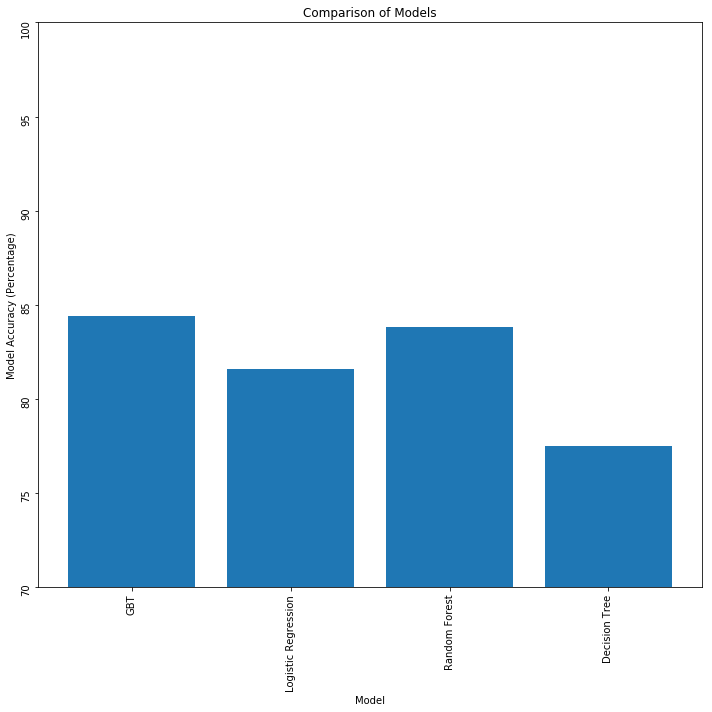

In [25]:
fig,ax = plt.subplots(figsize = (10,10))
ax.bar(plot_labels,plot_value)
ax.set_xlabel('Model')
ax.set_ylim(ymin=70,ymax = 100)
ax.set_ylabel('Model Accuracy (Percentage)')
ax.set_title("Comparison of Models")
ax.tick_params(labelrotation=90)
plt.tight_layout()
plt.show()

### Step 09 : Calculate the confusion matrix and find precision, recall and F1 score of each classification algorithm. Explain how the accuracy of the prediction can be improved.

In this step we try to evaluate the quality of the model using metrics other than accuracy. The steps involved are as follows :
- Compute the Confusion matrix for each model
- Compute Precision, recall and F1 score for each model for predicting rain tomorrow.


In [26]:
metrics_gbt = MulticlassMetrics(predictions_gbt.select(["prediction","RainTomorrow_indexer"]).rdd)
cm_gbt=metrics_gbt.confusionMatrix().toArray()

metrics_rf = MulticlassMetrics(predictions_rf.select(["prediction","RainTomorrow_indexer"]).rdd)
cm_rf=metrics_rf.confusionMatrix().toArray()

metrics_lr = MulticlassMetrics(predictions_lr.select(["prediction","RainTomorrow_indexer"]).rdd)
cm_lr=metrics_lr.confusionMatrix().toArray()

metrics_dt = MulticlassMetrics(predictions_dt.select(["prediction","RainTomorrow_indexer"]).rdd)
cm_dt=metrics_dt.confusionMatrix().toArray()


#### Calculating the Performance of each model

In [27]:
def calculate_accuracy(mat):
    accuracy_measures = dict()
    accuracy_measures["precision"] = precision = mat[1][1]/(mat[1][1] + mat[0][1] )
    accuracy_measures["recall"] = recall = mat[1][1]/(mat[1][1] + mat[1][0] )
    accuracy_measures["f1"] = (2*precision * recall )/ (precision + recall)
    return accuracy_measures
    

In [28]:
calculate_accuracy(cm_dt)

{'precision': 0.494834202499262,
 'recall': 0.529870403540196,
 'f1': 0.5117533326549303}

In [29]:
calculate_accuracy(cm_rf)

{'precision': 0.6893673110720563,
 'recall': 0.4959435254451586,
 'f1': 0.5768735829401311}

In [30]:
calculate_accuracy(cm_lr)

{'precision': 0.6294025157232704,
 'recall': 0.42176799072805815,
 'f1': 0.5050785439404454}

In [31]:
calculate_accuracy(cm_gbt)

{'precision': 0.7285921625544267,
 'recall': 0.4760299230850279,
 'f1': 0.5758348202905939}

### Improving accuracy of the model
There are quite a few statergies we can implement to further improve the accuracy of the model
- **Parameter Tuning** : In the model built above we have used the default parameters for most of the models. This does not guarantee a global optimal solution for each model. To improve the accuracy we can use loops and tune the model for each parameter such as learning rate, maximum depth of a tree, number of trees in random forest, number of iterations, etc to find the parameters that reduces the test error the most. 

- **Feature Selection** : In the model above we used our prior knowledge of the features, to remove a few columns in the data. Eventhough we reduced the number of features, we can still reduce the fetures using exploratory data analysis. We can reduce the columns further using the following logic 
    - removing features that have low correlation with target
    - removing features that have high correlation with other features
    - removing features that have low variance among themselves as the model would not learn much from these features and may overfit the data
Further we can use advanced feature selection techniques such as `step-forward feature selection`, `step-backward feature selection`, etc.
- **Cross validation** : Instead of using just one set of data to evaluate the performance of the model, we can use cross validation sets to reduce the variance and incraese the performance of the model. 
    